# Project: Wrangling and Analyze Data

## By Rofhiwa Kgomo

### Introduction
>In this project I will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. I will document my wrangling efforts in this Jupyter Notebook, plus showcase them through analyses and visualizations using Python (and its libraries) and reports.

>The dataset that I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

## 1. Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)


#### Importing required libraries

In [330]:
# importing required libraries
import os
import json
import re
from timeit import default_timer as timer
import datetime as dt
import time

import requests
import tweepy
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### twitter-archive-enhanced.csv file was downloaded manually from WeRateDogs's twitter archive.

In [177]:
# load the twitter_archive_enhanced.csv file

archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
920,756303284449767430,NaN,NaN,2016-07-22 01:42:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Pwease accept dis rose on behalf of dog. 11/10 https://t.co/az5BVcIV5I,NaN,NaN,NaN,https://twitter.com/dog_rates/status/756303284449767430/photo/1,11,10,None,None,None,None,None
468,817056546584727552,NaN,NaN,2017-01-05 17:13:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Chloe. She fell asleep at the wheel. Absolute menace on the roadways. Sneaky tongue slip tho. 11/10 https://t.co/r6SLVN2VUH,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817056546584727552/photo/1,11,10,Chloe,None,None,None,None
292,838083903487373313,NaN,NaN,2017-03-04 17:49:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Daisy. She's puppears to be rare as all h*ck. Only seven like her currently domesticated. 13/10 pettable af https://t.co/meUc8jufAO,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/838083903487373313/photo/1,https://twitter.com/dog_rates/status/838083903487373313/photo/1",13,10,Daisy,None,None,None,None
1367,702598099714314240,NaN,NaN,2016-02-24 20:56:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Sansa. She's gotten too big for her chair. Not so smol anymore. 11/10 once a pupper, always a pupper https://t.co/IpAoztle2s",NaN,NaN,NaN,https://twitter.com/dog_rates/status/702598099714314240/photo/1,11,10,Sansa,None,None,pupper,None
1601,686003207160610816,NaN,NaN,2016-01-10 01:54:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Hammond. He's a peculiar pup. Loves long walks. Bark barely audible. Too many legs. 3/10 must be rare https://t.co/NOIiRWr5Jf,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686003207160610816/photo/1,3,10,Hammond,None,None,None,None


In [178]:
archive_df.shape

(2356, 17)

In [179]:
# exploring columns from the file
list(archive_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)


#### image-predictions.tsv is a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction.

In [180]:
# Gathering additional data using requests library to download
# image-predictions.tsv file using provided url

# creating variables
url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split('/')[-1]

#response
r = requests.get(url)

# i write the content to a file but first checking if it already exists
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(r.content)

In [181]:
# I will verify if the request was successful
r

<Response [200]>

In [182]:
# now I load the file into a dataframe
img_predictions_df = pd.read_csv(file_name, sep='\t')
img_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [183]:
img_predictions_df.shape

(2075, 12)

In [184]:
# exploring columns of the new file
list(img_predictions_df)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

##### I will create an API dataframe from the json file. api_df

In [185]:
# Querying Twitter API for each tweet in the Twitter archive and save JSON in a text file
consumer_key = 'XvR0oSkSuHYGgisTfb8lccjQX'
consumer_secret = 'RHGonkc22o7bNER39MPNpQfmN8sC6vQymddsmSHM0eqSVPtiHG'
access_token = '2389413196-UKtA35vdr9un4dw6Uj1Pv8sDtSxjPaubYe4G6LT'
access_secret = 'RqMaW0ltsJB6nTsmXThPaubQkrTeYBpMwmMeSMw6FETUo'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
if not os.path.isfile('tweet_json.txt'):
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
end = timer()
print(end - start)
print(fails_dict)

0.0002397739999651094
{}


In [186]:
# list of dictionaries
tweets_data = []

with open('tweet_json.txt', 'r') as f:
    for line in f:
        tweet_data = json.loads(line)
        tweets_data.append(tweet_data)
        
api_df = pd.DataFrame(tweets_data)

In [187]:
# Exploring columns
list(api_df)

['contributors',
 'coordinates',
 'created_at',
 'display_text_range',
 'entities',
 'extended_entities',
 'favorite_count',
 'favorited',
 'full_text',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'truncated',
 'user']

In [188]:
api_df = api_df[['id', 'retweet_count', 'favorite_count']]

In [189]:
api_df.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [190]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


## 2. Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.


#### We can assess data for:

> - Quality: issues with content. Low quality data is also known as dirty data.
> - Tidiness: issues with structure that prevent easy analysis. Untidy data is also known as messy data.

#### Using two types of assessment:
> - Visual assessment: scrolling through the data.
> - Programmatic assessment: using code to view specific portions and summaries of the data.

### Quality issues
1. Quality issues pertain to the content of data. Low quality data is also known as dirty data. There are four dimensions of quality data:

2. Completeness: do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?

3. Validity: we have the records, but they’re not valid, i.e., they don’t conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).

4. Accuracy: inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient’s weight that is 5 lbs too heavy because the scale was faulty.

5. Consistency: inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

### Tidiness issues
1. Tidiness issues pertain to the structure of data. These structural problems generally prevent easy analysis. Untidy data is also known as messy data. The requirements for tidy data are:
2. Each variable forms a column.
3. Each observation forms a row.
4. Each type of observational unit forms a table.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

### Issue #1: Quality Issues

#### Define: Quality issues pertain to the content of data

#### Code

#### 2.a.i archive_df table

In [192]:
# Make copies of original pieces of data

archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
98,873213775632977920,NaN,NaN,2017-06-09 16:22:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps://t.co/Xp01EU3qyD https://t.co/V5lkvrGLdQ,NaN,NaN,NaN,"https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://twitter.com/dog_rates/status/873213775632977920/photo/1",12,10,Sierra,None,None,pupper,None
1392,700062718104104960,NaN,NaN,2016-02-17 21:02:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Eazy-E. He's colorful af. Must be rare. Submerged in Sprite (rad). Doesn't perform well when not wet. 6/10 https://t.co/UtFI7eUCjE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700062718104104960/photo/1,6,10,Eazy,None,None,None,None
813,771102124360998913,NaN,NaN,2016-08-31 21:47:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Charlie. He works for @TODAYshow. Super sneaky tongue slip here. 12/10 would pet until someone made me stop https://t.co/K5Jo7QRCvA,NaN,NaN,NaN,https://twitter.com/dog_rates/status/771102124360998913/photo/1,12,10,Charlie,None,None,None,None
1287,708356463048204288,NaN,NaN,2016-03-11 18:18:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Oliver. That is his castle. He protects it with his life. He's also squishy af. 10/10 would squish softly https://t.co/oSuEGw0BhX,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/708356463048204288/photo/1,https://twitter.com/dog_rates/status/708356463048204288/photo/1",10,10,Oliver,None,None,None,None
1638,684188786104872960,NaN,NaN,2016-01-05 01:44:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Yo Boomer I'm taking a selfie, grab your stick""\n""Ok make sure to get this rad hole I just dug in there""\n\nBoth 10/10 https://t.co/e0gbl9VFpA",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684188786104872960/photo/1,10,10,None,None,None,None,None


In [193]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [194]:
archive_df.tweet_id.duplicated().any()

False

In [195]:
archive_df[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [196]:
archive_df.query('rating_numerator == 1776')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10


In [197]:
archive_df.query('rating_denominator != 10')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [198]:
archive_df.rating_denominator.sort_values(ascending=False)

1120    170
902     150
1634    130
1779    120
1635    110
1228    90 
1254    80 
1843    80 
433     70 
1274    50 
1351    50 
1202    50 
1433    40 
1598    20 
1165    20 
1663    16 
342     15 
1662    11 
1068    11 
784     11 
800     10 
778     10 
777     10 
776     10 
779     10 
780     10 
799     10 
775     10 
781     10 
782     10 
797     10 
783     10 
796     10 
798     10 
773     10 
785     10 
786     10 
787     10 
788     10 
789     10 
790     10 
791     10 
792     10 
793     10 
794     10 
795     10 
774     10 
2355    10 
772     10 
746     10 
752     10 
751     10 
750     10 
749     10 
748     10 
747     10 
745     10 
754     10 
744     10 
743     10 
742     10 
741     10 
740     10 
739     10 
753     10 
755     10 
771     10 
764     10 
770     10 
801     10 
768     10 
767     10 
766     10 
765     10 
763     10 
756     10 
762     10 
761     10 
760     10 
759     10 
758     10 
757     10 
769     10 
805 

In [199]:
archive_df.rating_numerator.sort_values(ascending=False)

979     1776
313     960 
189     666 
188     420 
2074    420 
1120    204 
290     182 
902     165 
1779    144 
1634    143 
1635    121 
1228    99  
1843    88  
433     84  
1254    80  
695     75  
340     75  
1351    60  
1202    50  
1274    45  
1433    44  
763     27  
1712    26  
516     24  
1663    20  
55      17  
285     15  
291     15  
83      14  
866     14  
76      14  
78      14  
395     14  
369     14  
209     14  
1053    14  
924     14  
214     14  
101     14  
199     14  
95      14  
372     14  
149     14  
195     14  
533     14  
436     14  
164     14  
434     14  
141     14  
449     14  
448     14  
426     14  
490     14  
418     14  
447     14  
184     14  
185     14  
186     14  
123     14  
187     14  
404     14  
68      14  
117     14  
110     14  
1609    14  
446     14  
35      14  
758     14  
631     14  
268     14  
657     14  
347     14  
22      14  
41      14  
339     14  
298     14  
56      14  

> invalid and inconsistent rating data is both rating_numerator and rating_denominator

In [200]:
archive_df.name.value_counts()

None              745
a                 55 
Charlie           12 
Cooper            11 
Lucy              11 
Oliver            11 
Tucker            10 
Penny             10 
Lola              10 
Bo                9  
Winston           9  
the               8  
Sadie             8  
Toby              7  
Buddy             7  
Daisy             7  
Bailey            7  
an                7  
Koda              6  
Jack              6  
Dave              6  
Milo              6  
Bella             6  
Oscar             6  
Leo               6  
Rusty             6  
Scout             6  
Jax               6  
Stanley           6  
Sunny             5  
Louis             5  
Finn              5  
George            5  
Larry             5  
Bentley           5  
Alfie             5  
Oakley            5  
Gus               5  
Phil              5  
Chester           5  
very              5  
Sammy             5  
Gerald            4  
Luna              4  
Carl              4  
Bruce     

In [201]:
# default
# pd.set_option('display.max_colwidth', 50)
# max
pd.set_option('display.max_colwidth', -1)

In [202]:
# Checking names
# name == a
archive_df.query('name == "a"')[['tweet_id','text','name']].head()

,tweet_id,text,name
56,881536004380872706,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,a
649,792913359805018113,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
801,772581559778025472,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,a
1002,747885874273214464,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,a
1004,747816857231626240,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,a


In [203]:
archive_df.name.sort_values()

1035    Abby          
1021    Abby          
938     Ace           
1933    Acro          
1327    Adele         
1934    Aiden         
77      Aja           
480     Akumi         
820     Al            
875     Albert        
1954    Albert        
144     Albus         
412     Albus         
1115    Aldrick       
2046    Alejandro     
374     Alexander     
1189    Alexanderson  
486     Alf           
2238    Alfie         
661     Alfie         
367     Alfie         
1616    Alfie         
858     Alfie         
51      Alfy          
201     Alice         
1701    Alice         
1495    Amber         
1334    Ambrose       
2078    Amy           
2195    Amélie        
780     Anakin        
574     Anakin        
2144    Andru         
2084    Andy          
849     Angel         
443     Anna          
2063    Anthony       
2088    Antony        
1687    Apollo        
1059    Aqua          
1169    Archie        
1462    Archie        
1400    Archie        
2       Arc

In [204]:
# name == an
archive_df.query('name == "an"')[['tweet_id', 'text', 'name']]

,tweet_id,text,name
759,778396591732486144,RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR,an
1025,746369468511756288,This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt,an
1362,703041949650034688,This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR,an
2204,668636665813057536,This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg,an
2333,666337882303524864,This is an extremely rare horned Parthenon. Not amused. Wears shoes. Overall very nice. 9/10 would pet aggressively https://t.co/QpRjllzWAL,an
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,an
2349,666051853826850816,This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,an


In [205]:
# name == the
archive_df.query('name == "the"')[['tweet_id', 'text', 'name']]

,tweet_id,text,name
1527,690360449368465409,Stop sending in lobsters. This is the final warning. We only rate dogs. Thank you... 9/10 https://t.co/B9ZXXKJYNx,the
1603,685943807276412928,This is the newly formed pupper a capella group. They're just starting out but I see tons of potential. 8/10 for all https://t.co/wbAcvFoNtn,the
1797,677269281705472000,This is the happiest pupper I've ever seen. 10/10 would trade lives with https://t.co/ep8ATEJwRb,the
1815,676613908052996102,This is the saddest/sweetest/best picture I've been sent. 12/10 😢🐶 https://t.co/vQ2Lw1BLBF,the
2037,671561002136281088,This is the best thing I've ever seen so spread it like wildfire &amp; maybe we'll find the genius who created it. 13/10 https://t.co/q6RsuOVYwU,the
2212,668587383441514497,Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3,the
2345,666063827256086533,This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK,the
2346,666058600524156928,Here is the Rand Paul of retrievers folks! He's probably good at poker. Can drink beer (lol rad). 8/10 good dog https://t.co/pYAJkAe76p,the


In [206]:
# name == very 
archive_df.query('name == "very"')[['tweet_id', 'text', 'name']]

,tweet_id,text,name
773,776249906839351296,RT @dog_rates: We only rate dogs. Pls stop sending in non-canines like this Mongolian grass snake. This is very frustrating. 11/10 https://…,very
819,770655142660169732,We only rate dogs. Pls stop sending in non-canines like this Arctic Floof Kangaroo. This is very frustrating. 11/10 https://t.co/qlUDuPoE3d,very
1031,745422732645535745,We only rate dogs. Pls stop sending in non-canines like this Jamaican Flop Seal. This is very very frustrating. 9/10 https://t.co/nc53zEN0hZ,very
1097,736225175608430592,We only rate dogs. Please stop sending in non-canines like this Alaskan Flop Turtle. This is very frustrating. 10/10 https://t.co/qXteK6Atxc,very
1385,700747788515020802,We only rate dogs. Pls stop sending in non-canines like this Mongolian grass snake. This is very frustrating. 11/10 https://t.co/22x9SbCYCU,very


In [207]:
archive_df.query('(doggo != "None")')['name'].count()

97

In [208]:
archive_df.doggo.value_counts()

None     2259
doggo    97  
Name: doggo, dtype: int64

In [209]:
archive_df.query('(floofer != "None")')['name'].count()

10

In [210]:
archive_df.floofer.value_counts()

None       2346
floofer    10  
Name: floofer, dtype: int64

In [211]:
archive_df.query('(pupper != "None")')['name'].count()

257

In [212]:
archive_df.pupper.value_counts()

None      2099
pupper    257 
Name: pupper, dtype: int64

In [213]:
archive_df.query('(puppo != "None")')['name'].count()

30

In [214]:
archive_df.puppo.value_counts()

None     2326
puppo    30  
Name: puppo, dtype: int64

In [215]:
archive_df.query('(doggo != "None") & (floofer != "None")')[['text','name', 'doggo','floofer', 'pupper','puppo']]

,text,name,doggo,floofer,pupper,puppo
200,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",None,doggo,floofer,None,None


####  2.a.ii Image_predictions_df table

In [216]:
img_predictions_df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [217]:
img_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


> - ('p1', 'p1_conf', 'p1_dog', 'p2','p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog') Columns names are not informative. Names should be changed to be more informative.
> - Erroneous datatypes:
 -p1, p2 and p3 should be categorical
-tweet_id should be string

In [218]:
img_predictions_df.tweet_id.duplicated().any()

False

In [219]:
img_predictions_df.jpg_url.duplicated().any()

True

In [220]:
img_predictions_df[img_predictions_df.jpg_url.duplicated()]['tweet_id']

1297    752309394570878976
1315    754874841593970688
1333    757729163776290825
1345    759159934323924993
1349    759566828574212096
1364    761371037149827077
1368    761750502866649088
1387    766078092750233600
1407    770093767776997377
1417    771171053431250945
1427    772615324260794368
1446    775898661951791106
1453    776819012571455488
1456    777641927919427584
1463    778396591732486144
1476    780496263422808064
1487    782021823840026624
1495    783347506784731136
1510    786036967502913536
1522    788070120937619456
1538    790723298204217344
1541    791026214425268224
1564    793614319594401792
1569    794355576146903043
1571    794983741416415232
1579    796177847564038144
1588    798340744599797760
1589    798628517273620480
1590    798644042770751489
1591    798665375516884993
1592    798673117451325440
1593    798694562394996736
1594    798697898615730177
1601    799774291445383169
1605    800443802682937345
1615    802247111496568832
1619    802624713319034886
1

In [221]:
# Check tweets_id existance in both archive_df & image_predictions_df
img_predictions_df.tweet_id.isin(archive_df.tweet_id).all()

True

In [222]:
# Check tweets_id existance in both api_df & image_predictions_df
img_predictions_df.tweet_id.isin(api_df.id).all()

False

#### Missing tweets data

In [223]:
img_predictions_df.img_num.sort_values(ascending=False)

2040    4
1713    4
1768    4
1496    4
1978    4
779     4
1934    4
1024    4
1325    4
1790    4
1716    4
1829    4
1717    4
1549    4
1542    4
1543    4
1954    4
1893    4
1766    4
1617    4
1795    4
1800    4
1161    4
1337    4
144     4
1342    4
1372    4
1437    4
1914    4
1920    4
1286    4
1103    3
759     3
1842    3
1720    3
1824    3
1548    3
1630    3
1464    3
1727    3
1812    3
1813    3
1369    3
1988    3
1110    3
1237    3
1846    3
1034    3
1895    3
1899    3
1519    3
627     3
1196    3
808     3
1189    3
1523    3
1872    3
1925    3
1690    3
1498    3
1530    3
823     3
1694    3
1218    3
1856    3
1320    3
768     3
1850    3
1303    3
1725    3
1299    3
924     3
1642    3
2056    3
1442    3
1774    3
1426    3
1571    3
883     3
1447    3
1438    3
1603    3
1739    3
925     3
2016    3
479     3
609     3
1674    3
1396    3
1417    3
895     3
1453    3
602     3
1567    3
888     3
1171    3
382     3
1076    2
1268    2
1152    2


#### 2.a.iii api_df table

In [224]:
api_df.head(5)

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [225]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [226]:
api_df.id.duplicated().any()

False

In [227]:
# Comparing dataframes shapes
print(f"archive_df's shape: \n{archive_df.shape}\n")
print(f"img_predictions_df's shape: \n{img_predictions_df.shape}\n")
print(f"api_df's shape: \n{api_df.shape}")

archive_df's shape: 
(2356, 17)

img_predictions_df's shape: 
(2075, 12)

api_df's shape: 
(2354, 3)


> Dataframes do not have the same number of data

### Issue #2: Tidiness issues

#### Define

> Tidiness issues pertain to the structure of data. These structural problems generally prevent easy analysis. Untidy data is also known as messy data. The requirements for tidy data are:

> - Each variable forms a column.
> - Each observation forms a row.
> - Each type of observational unit forms a table.

### 2.b.i archive_df table

In [228]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


> - (doggo, floofer, pupper, puppo) should be categories of a single variable named "dog_stage".

### 2.b.ii image_predictions_df table

In [229]:
img_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 2.b.iii api_df table

In [230]:
api_df.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


> archive_df and api_df should be merged into one table on tweet_id

###  Assessment summary

### Summary on Quality


#### archive_df table:

> Erroneous datatype:
> - timestamp and retweeted_status_timestamp should be datetime.
> - tweet_id should be string.
> - (doggo, floofer, pupper, and puppo) are categories.
> - Inconsistent representation of null values as "None" strings in the (name, doggo, floofer, pupper, puppo) columns.
> - Invalid records: tweets in (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,  
> - retweeted_status_user_id, retweeted_status_timestamp) as they mean that they are not original tweets and should  not 
> - be included in analysis.
> - Incorrect names in the name column, names weren't successfully extracted from the text. i.e. (a, an, the, very).
> - Missing records in (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, 
> - retweeted_status_timestamp,expanded_url, doggo, floofer, pupper, puppo).

#### image_predictions_df table

> Erroneous datatypes:
> - tweet_id should be string.
> - Columns names are not informative. Names should be changed to be more informative.
> - Duplicated jpg_url records.
> - Missing records; indicates that there are tweets without images should be dropped.

#### api_df table

> Erroneous datatype:
> - id should be string
> - dataframes do not have the same number of data.



### Summary on Tidiness

> archive_df table:
> - (doggo, floofer, pupper, puppo) should be categories of a one variable named "dog_stage".
> General:
> - archive_df and api_df should be merged into one table on tweet_id
> image_predictions_df can be left as-is, because the observational units are images.



### Data Cleaning



#### Quality Issues

In [231]:
# make copies of the dataframes

archive_clean = archive_df.copy() 
img_predictions_clean = img_predictions_df.copy()
api_clean = api_df.copy()

In [232]:
# archive_df file has invalid names on index 391
# Checking index 391
archive_clean.loc[[391],['text', 'name']]

,text,name
391,"Here's a little more info on Dew, your favorite roaming doggo that went h*ckin viral. 13/10 \nhttps://t.co/1httNYrCeW https://t.co/KvaM8j3jhX",None


In [233]:
archive_clean.loc[391,'name'] = 'Dew'

In [234]:
# Samples of names that are "a, an, the, very"
archive_clean.query('(name == "a") | (name == "an") | (name == "the") | (name == "very")')[['text', 'name']].sample(25)

,text,name
2066,This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr,a
1017,This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2,a
2273,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,a
1877,C'mon guys. We've been over this. We only rate dogs. This is a cow. Please only submit dogs. Thank you...... 9/10 https://t.co/WjcELNEqN2,a
1527,Stop sending in lobsters. This is the final warning. We only rate dogs. Thank you... 9/10 https://t.co/B9ZXXKJYNx,the
2128,This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,a
2161,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl,a
773,RT @dog_rates: We only rate dogs. Pls stop sending in non-canines like this Mongolian grass snake. This is very frustrating. 11/10 https://…,very
801,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,a
2116,This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,a


In [235]:
archive_clean.loc[1193,['name']]

name    a
Name: 1193, dtype: object

In [236]:
# Using regualar exepressions to extract the correct name
# Test pattern
test_text_01 = "This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN"
test_pattern = re.compile(r'(?:name(?:d)?\s)(?:is\s)?(\w+)')

try:
    print(re.findall(test_pattern, test_text_01)[0])
except Exception as e:
    print("Name not found")
    print(e)

Hemry


In [237]:
test_text_02 = "Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR"
try:
    print(re.findall(test_pattern, test_text_02)[0])
except Exception as e:
    print("Name not found")
    print(e)

Name not found
list index out of range


In [238]:
# Creating a function to correct names -if available-

def correct_names(row):
    """Replace incorrect names with: 
        - Correct name extracted from text column using regex pattern.
        - 'None' if name is not availabe in text column"""
    
    if row['name'] == "a" or row['name'] == "an" or row['name'] == "the" or row['name'] == "very":
        pattern = re.compile(r'(?:name(?:d)?\s)(?:is\s)?(\w+)')

        try:
            correct_name = re.findall(pattern, row['text'])[0]
            
            row['name'] = row['name'].replace('an', correct_name)
            row['name'] = row['name'].replace('a', correct_name)
            row['name'] = row['name'].replace('the', correct_name)
            row['name'] = row['name'].replace('very', correct_name)

        except Exception as e:
            correct_name = "None"

            row['name'] = row['name'].replace('an', correct_name)
            row['name'] = row['name'].replace('a', correct_name)
            row['name'] = row['name'].replace('the', correct_name)
            row['name'] = row['name'].replace('very', correct_name)
        
        return row
    
    else:
        return row

In [239]:
# Applying the function
archive_clean = archive_clean.apply(correct_names, axis=1)

In [240]:
# Replace "None" Sting with None

archive_clean['name'] = archive_clean.name.replace({'None': None})

### Testing

In [241]:
# Test manually fixed names
archive_clean.loc[[391],['text', 'name']]

,text,name
391,"Here's a little more info on Dew, your favorite roaming doggo that went h*ckin viral. 13/10 \nhttps://t.co/1httNYrCeW https://t.co/KvaM8j3jhX",Dew


In [242]:
# Test (a, an, the, very) names
archive_clean.loc[[2346, 2034, 2161, 2125, 2204, 2273, 2198], ['text', 'name']]

,text,name
2346,Here is the Rand Paul of retrievers folks! He's probably good at poker. Can drink beer (lol rad). 8/10 good dog https://t.co/pYAJkAe76p,None
2034,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,Jacob
2161,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl,Alfredo
2125,This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,Cherokee
2204,This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg,BertBerta
2273,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,Kohl
2198,This is a wild Toblerone from Papua New Guinea. Mouth always open. Addicted to hay. Acts blind. 7/10 handsome dog https://t.co/IGmVbz07tZ,None


In [243]:
archive_clean.query('(name == "a") | (name == "an") | (name == "the") | (name == "very")')[['text', 'name']]

,text,name


In [244]:
# Check "None"
archive_clean.query('(name == "None")')[['text', 'name']]

,text,name


In [245]:
archive_clean.name.isnull().sum()

798

In [246]:
# tweet_id
archive_clean.tweet_id = archive_clean.tweet_id.astype(object)

In [247]:
# timestamp and retweeted_status_timestamp
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.retweeted_status_timestamp)

In [248]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          1558 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetim

In [249]:
# use subset
archive_clean.dropna(subset=['expanded_urls'], inplace=True)

In [250]:
archive_clean.expanded_urls.isnull().all()

False

In [251]:
archive_clean.iloc[:, -4:].describe()

,doggo,floofer,pupper,puppo
count,2297,2297,2297,2297
unique,2,2,2,2
top,None,None,None,None
freq,2203,2287,2042,2268


In [252]:

archive_clean.iloc[:, -4: ] = archive_clean.iloc[:, -4: ].replace("None", '')

In [253]:
archive_clean.iloc[:, -4: ].describe()

,doggo,floofer,pupper,puppo
count,2297,2297,2297,2297
unique,2,2,2,2
top,,,,
freq,2203,2287,2042,2268


### Cleaning Tidiness issues



##### archive_clean: Values represented as variables:

> - (doggo, floofer, pupper and puppo) columns should be one category column. (dog_stage)

##### Define

> - Create dog_stage column.
> - Fix double values.
> - Convert dog_stage dtype to category.

In [254]:
archive_clean['dog_stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo


In [255]:
# Dropping old columns
archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

In [256]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2297 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2297 non-null datetime64[ns]
source                        2297 non-null object
text                          2297 non-null object
retweeted_status_id           180 non-null float64
retweeted_status_user_id      180 non-null float64
retweeted_status_timestamp    180 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2297 non-null int64
rating_denominator            2297 non-null int64
name                          1558 non-null object
dog_stage                     2297 non-null object
dtypes: datetime64[ns](2), float64(4), int64(2), object(6)
memory usage: 269.2+ KB


In [257]:
archive_clean.dog_stage.value_counts()

                1923
pupper          243 
doggo           80  
puppo           28  
doggopupper     12  
floofer         9   
doggopuppo      1   
doggofloofer    1   
Name: dog_stage, dtype: int64

In [258]:
# fixing double stages
archive_clean.loc[archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo-pupper'
archive_clean.loc[archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo-puppo'
archive_clean.loc[archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo-floofer'

In [259]:
# fixing empty stings values with NaN
archive_clean.loc[archive_clean.dog_stage == "", 'dog_stage'] = np.nan

In [260]:
# Convert dog_stage to category
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

In [261]:
archive_clean.dog_stage.value_counts(dropna=False)

NaN              1923
pupper           243 
doggo            80  
puppo            28  
doggo-pupper     12  
floofer          9   
doggo-puppo      1   
doggo-floofer    1   
Name: dog_stage, dtype: int64

In [262]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2297 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2297 non-null datetime64[ns]
source                        2297 non-null object
text                          2297 non-null object
retweeted_status_id           180 non-null float64
retweeted_status_user_id      180 non-null float64
retweeted_status_timestamp    180 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2297 non-null int64
rating_denominator            2297 non-null int64
name                          1558 non-null object
dog_stage                     374 non-null category
dtypes: category(1), datetime64[ns](2), float64(4), int64(2), object(5)
memory usage: 253.8+ KB


### Cleaning image_predictions_clean 

#### Quality issues
##### image_predictions_clean: columns' names:
> - Columns names are not informative. Names should be changed to be more informative

##### Define
> - Renaming the columns to be more descriptive.

In [263]:
# Old columns' names
list(img_predictions_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [264]:
# New descriptive columns' names
columns = ['tweet_id', 'jpg_url', 'img_num',
           'prediction_1', 'confidence_1', 'is_dog_1', 
           'prediction_2', 'confidence_2', 'is_dog_2',
           'prediction_3', 'confidence_3', 'is_dog_3',]

img_predictions_clean.columns = columns

In [265]:
list(img_predictions_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'prediction_1',
 'confidence_1',
 'is_dog_1',
 'prediction_2',
 'confidence_2',
 'is_dog_2',
 'prediction_3',
 'confidence_3',
 'is_dog_3']

In [266]:
# Convert tweet_id dtype to object using astype().

img_predictions_clean.tweet_id = img_predictions_clean.tweet_id.astype(object)

In [267]:
img_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id        2075 non-null object
jpg_url         2075 non-null object
img_num         2075 non-null int64
prediction_1    2075 non-null object
confidence_1    2075 non-null float64
is_dog_1        2075 non-null bool
prediction_2    2075 non-null object
confidence_2    2075 non-null float64
is_dog_2        2075 non-null bool
prediction_3    2075 non-null object
confidence_3    2075 non-null float64
is_dog_3        2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### api_clean dataset

#### Quality issues
##### api_clean: id datatype
> - Erroneous datatype: id should be string

##### Define

Convert tweet_id datatype to object

In [268]:
api_clean.id = api_clean.id.astype(object)

In [269]:
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


In [270]:
# Cleaning tidiness issues

archive_clean = pd.merge(left=archive_clean, right=api_clean, how='left', left_on='tweet_id', right_on='id')

In [271]:
# drop 'id' column
archive_clean.drop(columns=['id'], inplace=True)

In [272]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2296
Data columns (total 16 columns):
tweet_id                      2297 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2297 non-null datetime64[ns]
source                        2297 non-null object
text                          2297 non-null object
retweeted_status_id           180 non-null float64
retweeted_status_user_id      180 non-null float64
retweeted_status_timestamp    180 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2297 non-null int64
rating_denominator            2297 non-null int64
name                          1558 non-null object
dog_stage                     374 non-null category
retweet_count                 2295 non-null float64
favorite_count                2295 non-null float64
dtypes: category(1), datetime64[ns](2), float64(6), int64(2), o

### Tweets without images should be removed

#### Define
Use image_prediction_clean table to idintify the tweets without images in the archive table and remove them.

In [273]:
# Number of tweets with images
tweets_with_images = list(img_predictions_clean.tweet_id.unique())
len(tweets_with_images)

2075

In [274]:
# Checkin that all tweets are in archive_clean data set
archive_clean.tweet_id.isin(tweets_with_images).sum()

2075

In [275]:
# Dropping the other tweets
archive_clean = archive_clean[archive_clean.tweet_id.isin(tweets_with_images)]

In [276]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2296
Data columns (total 16 columns):
tweet_id                      2075 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2075 non-null datetime64[ns]
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null datetime64[ns]
expanded_urls                 2075 non-null object
rating_numerator              2075 non-null int64
rating_denominator            2075 non-null int64
name                          1446 non-null object
dog_stage                     321 non-null category
retweet_count                 2073 non-null float64
favorite_count                2073 non-null float64
dtypes: category(1), datetime64[ns](2), float64(6), int64(2), obje

In [277]:
# Non original tweets removal (retweets and replies):
# getting retweets
retweets = archive_clean.retweeted_status_id.notnull()
archive_clean[retweets].shape[0]

81

In [278]:
# dropping retweets
archive_clean = archive_clean[~retweets]

In [279]:
# getting replies
replies = archive_clean.in_reply_to_status_id.notnull()
archive_clean[replies].shape[0]

23

In [280]:
# dropping replies
archive_clean = archive_clean[~replies]

In [281]:
# Dropping retweets and replies columns
archive_clean.drop(columns=['in_reply_to_status_id', 
                    'in_reply_to_user_id', 
                    'retweeted_status_id', 
                    'retweeted_status_user_id', 
                    'retweeted_status_timestamp'], inplace=True)

In [282]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2296
Data columns (total 11 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1397 non-null object
dog_stage             303 non-null category
retweet_count         1971 non-null float64
favorite_count        1971 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 171.7+ KB


In [283]:
# Rating numarator and denominator

# describe
archive_clean.loc[:,['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,1971.000000,1971.000000
mean,12.223237,10.477423
std,41.634034,6.853275
min,0.000000,2.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [284]:
# numerator
archive_clean.rating_numerator.unique()

array([  13,   12,   14,    5,   11,    6,   10,    0,   84,   24,   75,
         27,    3,    7,    8,    9,    4,  165, 1776,  204,   50,   99,
         80,   45,   60,   44,  121,   26,    2,  144,   88,    1,  420])

In [285]:
archive_clean.rating_numerator.value_counts()

12      446
10      417
11      392
13      253
9       150
8       95 
7       52 
5       33 
14      33 
6       32 
3       19 
4       16 
2       9  
1       5  
1776    1  
24      1  
26      1  
420     1  
27      1  
44      1  
45      1  
50      1  
60      1  
75      1  
80      1  
84      1  
88      1  
99      1  
121     1  
144     1  
165     1  
204     1  
0       1  
Name: rating_numerator, dtype: int64

In [286]:
# denominator
archive_clean.rating_denominator.unique()

array([ 10,  70,   7, 150,  11, 170,  20,  50,  90,  80,  40, 110, 120,   2])

In [287]:
archive_clean.rating_denominator.value_counts()

10     1954
50     3   
80     2   
11     2   
170    1   
150    1   
120    1   
110    1   
90     1   
70     1   
40     1   
20     1   
7      1   
2      1   
Name: rating_denominator, dtype: int64

In [288]:
# Capturing outliers
odd_numerator = np.logical_or(archive_clean.rating_numerator > 15, archive_clean.rating_numerator <= 5)
odd_denominator = np.logical_or(archive_clean.rating_denominator > 10, archive_clean.rating_denominator < 10)

In [289]:
odd_denominator.sum()

17

In [290]:
odd_numerator.sum()

101

In [291]:
# boolean masking 
odd_ratings = archive_clean.loc[np.logical_or(odd_denominator, odd_numerator), ['text', 'rating_numerator', 'rating_denominator']]
odd_ratings.shape

(103, 3)

In [292]:
# Max display
pd.set_option('display.max_rows', None)

In [293]:
odd_ratings

,text,rating_numerator,rating_denominator
44,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
298,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
410,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
491,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
667,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
700,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,5,10
733,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
735,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,3,10
851,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP,4,10
870,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150


In [294]:
# boolean masking 
odd_ratings = archive_clean.loc[np.logical_or(odd_denominator, odd_numerator), ['text', 'rating_numerator', 'rating_denominator']]
odd_ratings.shape

(103, 3)

In [295]:
# Max display
pd.set_option('display.max_rows', None)

In [296]:
odd_ratings

,text,rating_numerator,rating_denominator
44,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
298,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
410,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
491,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
667,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
700,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,5,10
733,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
735,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,3,10
851,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP,4,10
870,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150


### After visual inspecting and observations:

#### We can summarize these odd values into two categories as below

##### Categoryt I:
> - Ratings are floats (fraction numerator) and aren't succefully captuerd from the text.
> - We could develop a regex pattern to capture the whole rating.
> - on indexes: (44, 667, 733, 1664).

##### Category II:
> - Captured the wrong rating as the text have other numbers other than the rating.
> - There are more than one dog in the image.
> - We could manually fix these.
> - on indexes:
> 410: 84/70 there are 7 dogs, the correct rating is 12/10.
> 491: ...smiles 24/7.. is an expression not a rating, there is no rating in the text.
> 870: 165/150 there are 15 dogs, the correct rating is 11/10.
> 946: 1776/10 is an abnormal value should be deleted.

In [297]:
# test regex pattern
test_pattern = re.compile(r'(\d+\.?\d?\d?)\/(\d{1,3})')

test_text_01 = "This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948"
test_text_02 = "Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD"

match_01 = re.findall(test_pattern, test_text_01)
match_02 = re.findall(test_pattern, test_text_02)

match_01, match_02

([('13.5', '10')], [('11.26', '10')])

In [298]:
# Fixing
pattern = r'(\d+\.?\d?\d?)\/(\d{1,3})'

archive_clean['rating_numerator'] = archive_clean.text.str.extract(pattern, expand=False).astype('float')

In [299]:
archive_clean.loc[[44, 667, 733, 1664], ['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
44,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10
667,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10
733,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10
1664,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10


In [300]:
# 410: correct rating is 12/10
archive_clean.loc[410, ['rating_numerator', 'rating_denominator']] =  [12, 10]
# 491: there is no rating in the text
archive_clean.loc[491, ['rating_numerator', 'rating_denominator']] =  [np.nan, np.nan]
# 870: correct rating is 11/10
archive_clean.loc[870, ['rating_numerator', 'rating_denominator']] =  [11, 10]
# 946: abnormal value should be deleted
archive_clean.drop(946, inplace=True)
# 1034: correct rating is 14/10
archive_clean.loc[1034, ['rating_numerator', 'rating_denominator']] =  [14, 10]
# 1085: correct rating is 12/10
archive_clean.loc[1085, ['rating_numerator', 'rating_denominator']] =  [12, 10]

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

#### Exporting cleaned data to CSV files, and SQL databases

### To CSV Files

In [301]:
# to CSV files
archive_clean.to_csv('twitter_archive_master.csv', index=False, encoding='utf-8')
img_predictions_clean.to_csv('img_predictions_master.csv', index=False, encoding='utf-8')

#### Storing To database

In [302]:
# to database
# Create SQLAlchemy Engine
engine = create_engine('sqlite:///master_df.db')

In [303]:
# archive_clean.to_sql('twitter_archive_master', engine, index=False)
# img_predictions_clean.to_sql('img_predictions_master', engine, index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### 1. Favorites and retweets analysis

In [304]:
archive_clean.rating_numerator.describe()

count    1969.000000
mean     11.067435  
std      10.844381  
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      420.000000 
Name: rating_numerator, dtype: float64

In [305]:
archive_clean[['retweet_count' , 'favorite_count']].describe()

,retweet_count,favorite_count
count,1970.000000,1970.000000
mean,2784.455838,8950.822335
std,4698.855639,12270.678075
min,16.000000,81.000000
25%,628.250000,1991.000000
50%,1367.000000,4145.500000
75%,3239.500000,11406.750000
max,79515.000000,132810.000000


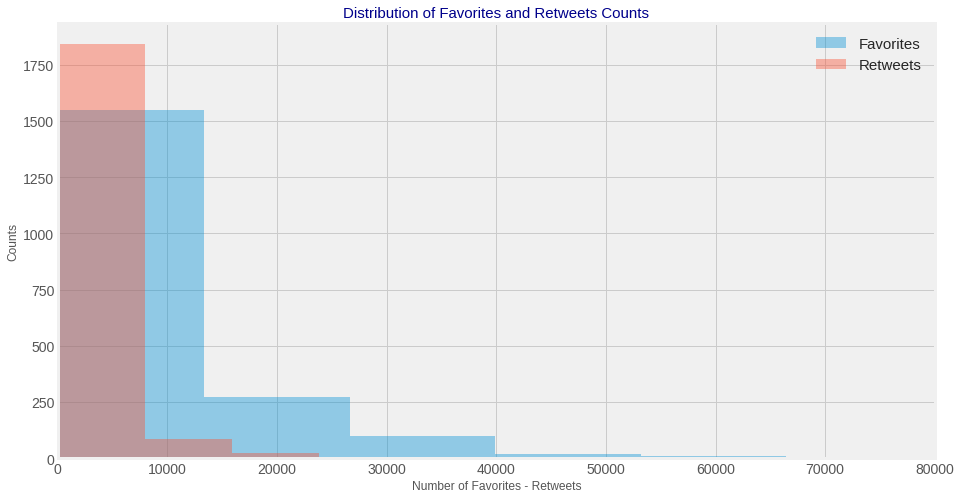

In [306]:
plt.figure(figsize=(14, 8))
plt.style.use('fivethirtyeight')

plt.hist(archive_clean.favorite_count, alpha=.4, label='Favorites')
plt.hist(archive_clean.retweet_count, alpha=.4, label='Retweets')

plt.title('Distribution of Favorites and Retweets Counts', color='darkblue', fontsize=15)
plt.xlabel('Number of Favorites - Retweets', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xlim(-1, 80000)

plt.legend(prop={'size': 15})

plt.savefig('.\img\Favs_retweets_counts')

plt.show()

#### Distribution of favorites counts and retweets count follow the same pattern.

#### Now we look at the corrolation

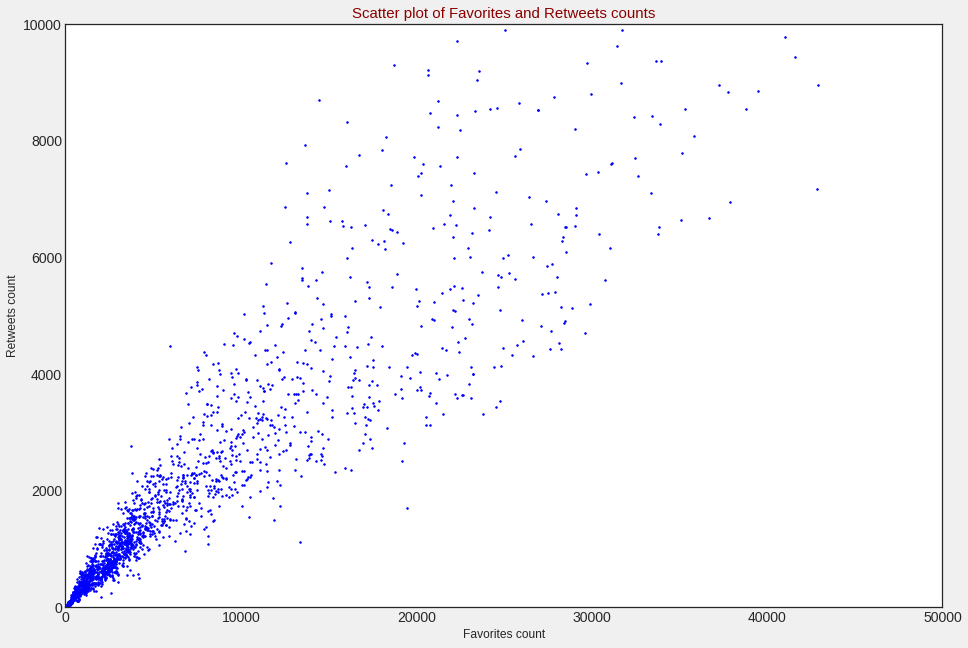

In [307]:
# Scatter plot
plt.figure(figsize=(14, 10))
plt.style.use('seaborn-white')

plt.plot(archive_clean.favorite_count, archive_clean.retweet_count,'bo', markersize=1.5)
plt.title('Scatter plot of Favorites and Retweets counts', color='darkred', fontsize=15)
plt.xlabel('Favorites count', fontsize=12)
plt.ylabel('Retweets count', fontsize=12)

plt.xlim(0, 50000)
plt.ylim(0, 10000)



plt.savefig('.\img\scatter_favs_retweets')
plt.show()

#### Now I will check the logs and likes

In [308]:
# make copies of dataframes to apply log10
log_df = archive_clean.copy()
log_df = log_df[['favorite_count', 'retweet_count']]
log_df['favorite_count'] = archive_clean.favorite_count.apply(lambda x: np.log10(x))
log_df['retweet_count'] = archive_clean.retweet_count.apply(lambda x: np.log10(x))

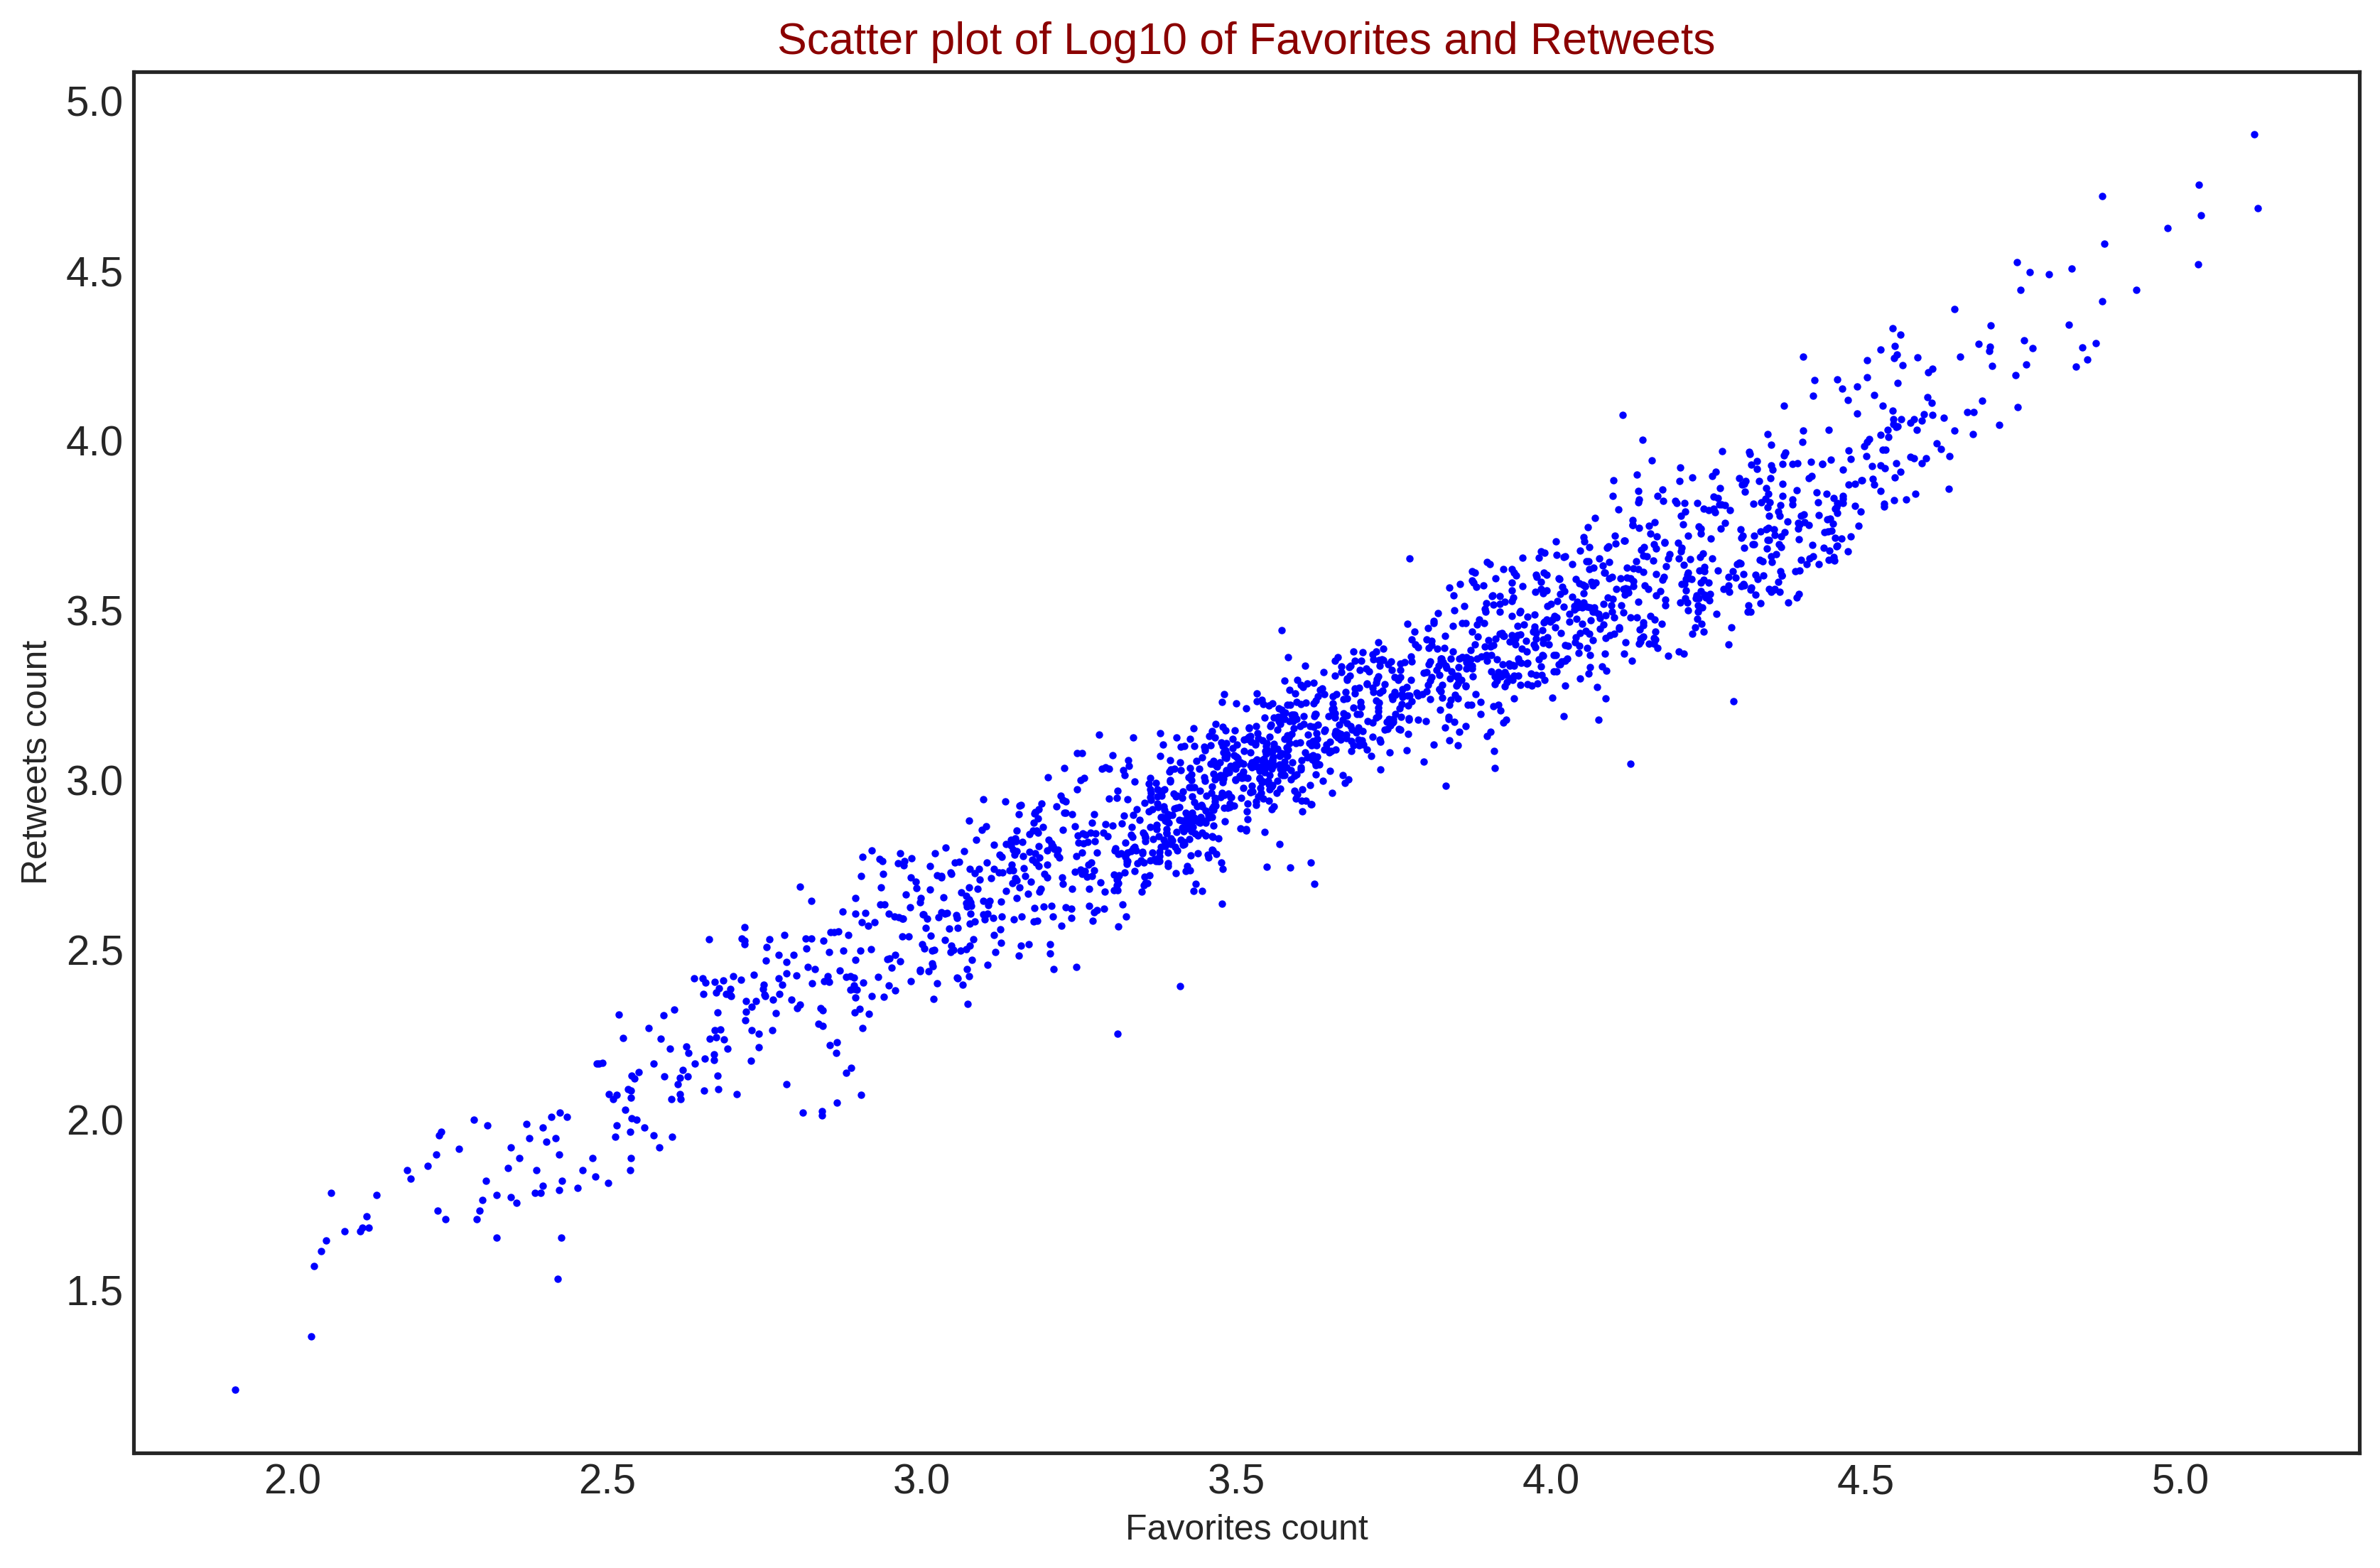

In [309]:
# Plot
plt.figure(figsize=(12, 8), dpi=300)
plt.style.use('seaborn-white')


plt.plot(log_df.favorite_count, log_df.retweet_count, 'bo', markersize=1.5)

plt.title('Scatter plot of Log10 of Favorites and Retweets',color='darkred', fontsize=15)
plt.xlabel('Favorites count', fontsize=12)
plt.ylabel('Retweets count', fontsize=12)


plt.savefig('.\img\Scatter_log-favs_log-retweets')

plt.show()

#### Most people who like the tweets almost retweets them.

### 2. Favorites and retweets analysis by months and days

In [310]:
# Copy
date_df = archive_clean.copy()
date_df = date_df[['timestamp', 'retweet_count' ,'favorite_count']]

# extract 'month' and 'day' columns from timestamp
date_df['month'] = date_df.timestamp.dt.month_name()
date_df['day'] = date_df.timestamp.dt.day_name()

date_df.sample(10)

,timestamp,retweet_count,favorite_count,month,day
1195,2016-03-25 17:03:49,1440.0,4802.0,March,Friday
524,2016-12-04 00:30:29,1972.0,8680.0,December,Sunday
2001,2015-11-30 15:51:24,119.0,508.0,November,Monday
1684,2015-12-24 00:58:27,15839.0,39726.0,December,Thursday
1593,2016-01-05 01:00:50,764.0,2215.0,January,Tuesday
1013,2016-06-16 18:26:48,4185.0,8671.0,June,Thursday
1805,2015-12-12 03:47:46,316.0,1122.0,December,Saturday
1574,2016-01-07 03:30:07,1191.0,3523.0,January,Thursday
1151,2016-04-08 20:46:50,1137.0,2730.0,April,Friday
97,2017-06-08 14:20:41,3884.0,15029.0,June,Thursday


In [311]:
# number of favorites and retweets by month
month_df = date_df.groupby('month').sum()
month_df

,retweet_count,favorite_count
month,,
April,320884.0,1178300.0
August,232007.0,681425.0
December,837739.0,2142175.0
February,457818.0,1664466.0
January,677532.0,1965498.0
July,552250.0,2166996.0
June,616602.0,2033679.0
March,424441.0,1514301.0
May,440206.0,1561307.0


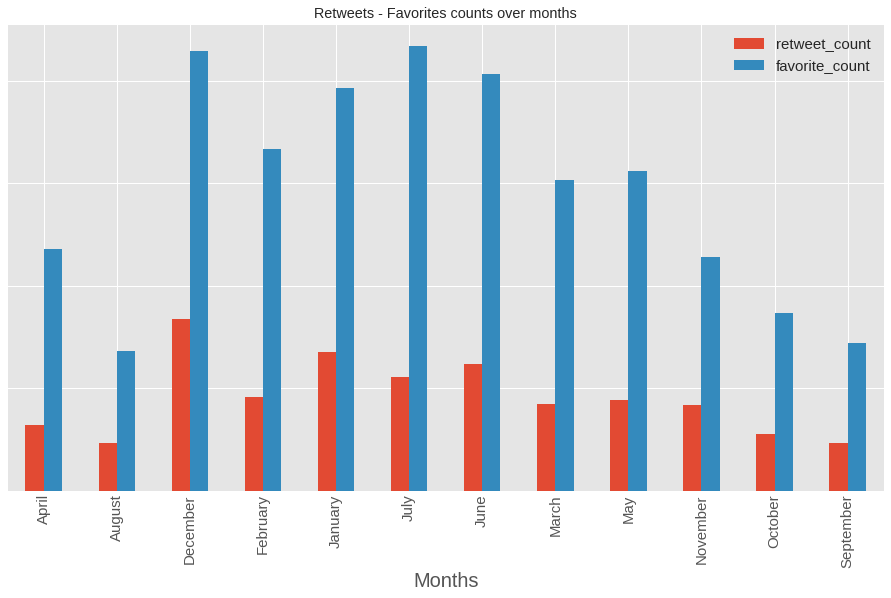

In [312]:
# plot
plt.style.use('ggplot')

ax = month_df[['retweet_count','favorite_count']].plot(kind='bar', title ="Retweets - Favorites counts over months" ,figsize=(14, 8), legend=True, fontsize=15)

ax.set_xlabel("Months", fontsize=20)
ax.set_yticklabels([])

plt.legend(prop={'size':15})

plt.savefig('.\img\Retweets-favs-months')

#### The Highest number of Retweets and Favorites were in July and December.

In [313]:
# number of favorites and retweets by day
day_df = date_df.groupby('day').sum()
day_df

,retweet_count,favorite_count
day,,
Friday,782096.0,2439293.0
Monday,857298.0,2762536.0
Saturday,742796.0,2248024.0
Sunday,680607.0,2220318.0
Thursday,711520.0,2347013.0
Tuesday,796491.0,2666200.0
Wednesday,914570.0,2949736.0


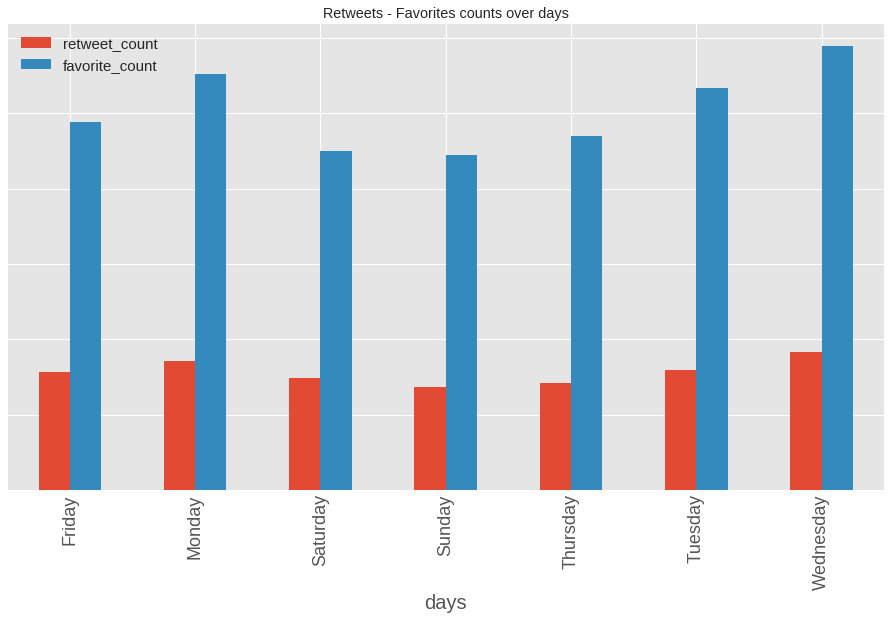

In [314]:
# plot
ax = day_df[['retweet_count','favorite_count']].plot(kind='bar', title ="Retweets - Favorites counts over days", figsize=(14, 8), legend=True, fontsize=18)

ax.set_xlabel("days", fontsize=20)
ax.set_yticklabels([])

plt.legend(prop={'size':15})

plt.savefig('.\img\Retweets-favs-day')

#### The Highest number of Retweets and Favorites were on Wednesday.

### 3. Dog breed analysis


#### I will figure out which breeds get favorited the most.

In [315]:
# copy of images
images_copy = img_predictions_clean.copy()
images_copy = images_copy[['tweet_id' ,'prediction_1' ,'confidence_1', 'is_dog_1']]
images_copy.shape

(2075, 4)

In [316]:
# copy of archive 
archive_copy = archive_clean.copy()
archive_copy = archive_copy[['tweet_id' , 'rating_numerator' , 'retweet_count' , 'favorite_count']]
archive_copy.shape

(1970, 4)

In [317]:
# left merge the datasets
breed_clean = pd.merge(left=archive_copy, right=images_copy, on='tweet_id')
breed_clean.shape

(1970, 7)

In [318]:
breed_clean.head()

,tweet_id,rating_numerator,retweet_count,favorite_count,prediction_1,confidence_1,is_dog_1
0,892420643555336193,13.0,8853.0,39467.0,orange,0.097049,False
1,892177421306343426,13.0,6514.0,33819.0,Chihuahua,0.323581,True
2,891815181378084864,12.0,4328.0,25461.0,Chihuahua,0.716012,True
3,891689557279858688,13.0,8964.0,42908.0,paper_towel,0.170278,False
4,891327558926688256,12.0,9774.0,41048.0,basset,0.555712,True


In [319]:
# select only dogs == true
breed_clean = breed_clean[breed_clean['is_dog_1'] == True]

In [320]:
# most favs
breed_fav = breed_clean.groupby('prediction_1').sum().reset_index()
breed_fav = breed_fav[['prediction_1', 'favorite_count']]
breed_fav = breed_fav.sort_values('favorite_count', ascending = False)[:20]
breed_fav

,prediction_1,favorite_count
87,golden_retriever,1693475.0
35,Labrador_retriever,1116811.0
47,Pembroke,994755.0
15,Chihuahua,673526.0
53,Samoyed,542991.0
22,French_bulldog,465738.0
79,chow,404241.0
99,pug,320223.0
81,cocker_spaniel,315825.0
48,Pomeranian,299114.0


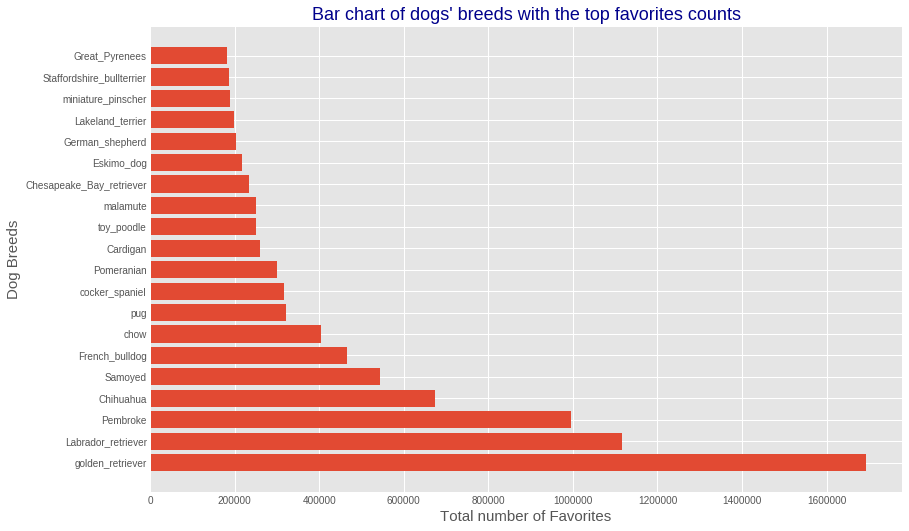

In [321]:
# plot
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

plt.barh(range(len(breed_fav.prediction_1)), breed_fav.favorite_count) 

plt.yticks(range(len(breed_fav.prediction_1)), breed_fav.prediction_1)

plt.title('Bar chart of dogs\' breeds with the top favorites counts', color = 'darkblue', fontsize=18)

plt.ylabel('Dog Breeds', fontsize=15)
plt.xlabel('Total number of Favorites',fontsize=15)


plt.savefig('.\img\Dog-breed-favs')
plt.show()

#### The Golden Retriever has the most amount of favorites, followed by the Labrador Retriever and Pembroke.

### Insights:
1. The Highest number of Retweets and Favorites were mostly in July and December and June being on the 3rd place.

2. The Highest number of Retweets and Favorites were on Wednesday followed by monday then Tuesdays.

3. The Golden Retriever has the most amount of favorites, followed by the Labrador Retriever and Pembroke.